## Exploring HGMM

Questions:

Across all cells,

- What is the relation between the # of chimeras and the # and FS of real molecules (same gene)?
- What is the relation between the FS of chimeras and the # and FS of real molecules (same gene)?
- What is the relation between the # of chimeras and number of real molecules (other genes)?

In a given cell,

- What is the relation between the total # of real molecules and expression of inidividual genes (notion of droplet efficiency)?
- What is the relation between the # of chimeras (summed over all genes) and the # of real molecules (summed over all genes)?

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import operator
from bisect import bisect_left, bisect_right
from commons import *
import tables
import scipy.sparse as sp

from fingerprint import SingleCellFingerprintBase, SingleCellFingerprintDTM

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [95]:
dataset_name = 'hgmm_1k'
sc_fingerprint_path = '/home/jupyter/data/10x/hgmm_1k_v1_sc_fingerprint.pkl'

In [96]:
dataset_name = 'cho_hca_1'
sc_fingerprint_path = '/home/jupyter/data/10x/CHO_HCA_1_sc_fingerprint.pkl'

In [82]:
# load fingerprint and instantiate the data-store
sc_fingerprint_base = SingleCellFingerprintBase.load(sc_fingerprint_path)
sc_fingerprint_base = sc_fingerprint_base.filter_genes(
    max_good_turing=1.,
    min_total_gene_expression=1.).sort_genes_by_expression()
sc_fingerprint_dtm = SingleCellFingerprintDTM(sc_fingerprint_base)

Calculating and caching "SingleCellFingerprintBase.good_turing_estimator_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Number of genes failed the maximum Good-Turing criterion: 29121
Number of genes failed the minimum expression criterion: 29121
Number of genes failed both criteria: 29121
Number of retained genes: 31615
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...


In [98]:
human_prefix = 'hg19'
mouse_prefix = 'mm10'
human_gene_indices = [i_gene
                      for i_gene, gene_idx in enumerate(sc_fingerprint_base.gene_idx_list)
                      if sc_fingerprint_base.gene_names_list[i_gene].find(human_prefix) != -1]
mouse_gene_indices = [i_gene
                      for i_gene, gene_idx in enumerate(sc_fingerprint_base.gene_idx_list)
                      if sc_fingerprint_base.gene_names_list[i_gene].find(mouse_prefix) != -1]

In [99]:
joint_count_matrix_csc = sp.csc_matrix(sc_fingerprint_base.sparse_count_matrix_csr)
human_count_matrix_csr = sp.csr_matrix(joint_count_matrix_csc[:, human_gene_indices])
mouse_count_matrix_csr = sp.csr_matrix(joint_count_matrix_csc[:, mouse_gene_indices])

In [100]:
human_total_expr = np.asarray(np.sum(human_count_matrix_csr, -1)).flatten()
mouse_total_expr = np.asarray(np.sum(mouse_count_matrix_csr, -1)).flatten()

In [101]:
human_cell_indices = np.where((human_total_expr > 1e3) & (mouse_total_expr < 1e3))[0]
mouse_cell_indices = np.where((mouse_total_expr > 1e3) & (human_total_expr < 1e3))[0]

Text(0.5, 0, 'Human UMI count')

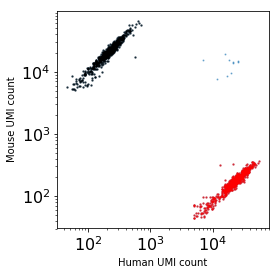

In [103]:
plt.scatter(human_total_expr, mouse_total_expr, s=1, alpha=0.5)
plt.scatter(human_total_expr[human_cell_indices], mouse_total_expr[human_cell_indices], color='red', s=2, alpha=0.5)
plt.scatter(human_total_expr[mouse_cell_indices], mouse_total_expr[mouse_cell_indices], color='black', s=2, alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.gca().set_aspect('equal')
plt.ylabel('Mouse UMI count')
plt.xlabel('Human UMI count')

In [104]:
dtm_e_hi_map_path = '/home/jupyter/data/10x/out/\
hgmm_1k_v1__all_genes__no_zero_inflation__rc_18/e_hi_map__full.npy'
e_hi_map = np.load(dtm_e_hi_map_path)

In [105]:
human_total_expr__dtm = np.sum(e_hi_map[:, human_gene_indices], -1)
mouse_total_expr__dtm = np.sum(e_hi_map[:, mouse_gene_indices], -1)

(0, 100000)

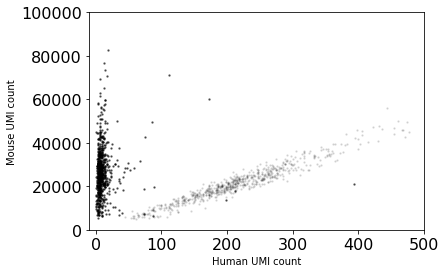

In [108]:
plt.scatter(
    human_total_expr[human_cell_indices],
    mouse_total_expr[human_cell_indices],
    color='red', s=2, alpha=0.1)

plt.scatter(
    human_total_expr__dtm[human_cell_indices],
    mouse_total_expr__dtm[human_cell_indices],
    color='red', s=2, alpha=0.5)

plt.scatter(
    human_total_expr[mouse_cell_indices],
    mouse_total_expr[mouse_cell_indices],
    color='black', s=2, alpha=0.1)

plt.scatter(
    human_total_expr__dtm[mouse_cell_indices],
    mouse_total_expr__dtm[mouse_cell_indices],
    color='black', s=2, alpha=0.5)

plt.ylabel('Mouse UMI count')
plt.xlabel('Human UMI count')

plt.xlim((-10, 500))
plt.ylim((0, 100000))

(0, 15)

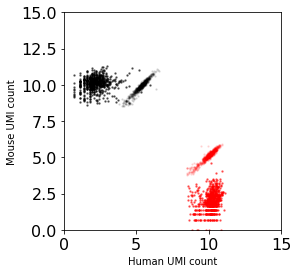

In [107]:
plt.scatter(
    np.log1p(human_total_expr[human_cell_indices]),
    np.log1p(mouse_total_expr[human_cell_indices]),
    color='red', s=2, alpha=0.1)

plt.scatter(
    np.log1p(human_total_expr__dtm[human_cell_indices]),
    np.log1p(mouse_total_expr__dtm[human_cell_indices]),
    color='red', s=2, alpha=0.5)

plt.scatter(
    np.log1p(human_total_expr[mouse_cell_indices]),
    np.log1p(mouse_total_expr[mouse_cell_indices]),
    color='black', s=2, alpha=0.1)

plt.scatter(
    np.log1p(human_total_expr__dtm[mouse_cell_indices]),
    np.log1p(mouse_total_expr__dtm[mouse_cell_indices]),
    color='black', s=2, alpha=0.5)

plt.gca().set_aspect('equal')
plt.ylabel('Mouse UMI count')
plt.xlabel('Human UMI count')

plt.xlim((0, 15))
plt.ylim((0, 15))